In [3]:
import h5py
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Conv2D, AveragePooling2D, Flatten, MaxPooling2D, Dropout
from keras.utils.io_utils import HDF5Matrix
from keras.objectives import categorical_crossentropy
from keras import backend as K

%matplotlib inline
from matplotlib import pylab as pl

Using TensorFlow backend.


In [5]:
def np_softmax(logits):
    Z = np.sum(np.exp(logits), 1, keepdims=True)
    return np.divide(np.exp(logits), Z)

def np_sample_gumbel(shape, eps=1e-20):
    """Sample from Gumbel(0, 1)"""
    U = np.random.uniform(0,1, shape)
    return -np.log(-np.log(U + eps) + eps)

def np_gumbel_softmax_sample(logits, temperature, inp, lam=0.5):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = lam*inp*logits + (1-lam)*np_sample_gumbel(np.shape(logits))
    return np_softmax( y / temperature)

def np_gumbel_softmax(logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    y = np_gumbel_softmax_sample(logits, temperature)
    if hard:
        k = np.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = (np.equal(y,np.max(y,1,keepdims=True)))
#         y = tf.stop_gradient(y_hard - y) + y
    return y_hard-y+y

In [6]:
def sample_gumbel(shape, eps=1e-20):
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(inp, logits, temperature, lam=0.5):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = lam*inp*logits + (1-lam)*sample_gumbel(tf.shape(inp))
    return tf.nn.softmax( y / temperature, dim=1)

def gumbel_softmax(inp, logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(inp, logits, temperature)
    if hard:
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y

In [143]:
?Conv2D

In [7]:
tf.reset_default_graph()


In [8]:
inp = tf.placeholder(tf.float32, [None, 4, 1000, 1], name='dna_input')
target = tf.placeholder(tf.float32, [None, 2], name='label')
# temperature
tau = tf.constant(1.0, name='temperature')

with tf.variable_scope('mutator'):    
    cn1 = Conv2D(64, [4, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_1')

    cn2 = Conv2D(32, [1, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_2')
    mp1 = MaxPooling2D((1, 2), strides=(1, 2))
    cn3 = Conv2D(16, [1, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_3')
    mp2 = MaxPooling2D((1, 2), strides=(1, 2))
    fl1 = Flatten()
    dn1 = Dense(50, name='representation', activation='tanh')

    dn2m = Dense(1000, name='prediction', activation='linear')
    mutant_repr = dn1(fl1(mp2(cn3(mp1(cn2(cn1(inp)))))))
    logits  =dn2m(mutant_repr)
    logits_dna = tf.reshape(logits, [-1, 1, 1000, 1])
    # sample and reshape back (shape=(batch_size,N,K))
    # set hard=True for ST Gumbel-Softmax
    mutant = gumbel_softmax(inp, logits_dna, tau, hard=False)
    
with tf.variable_scope('discriminator'):
    cn1 = Conv2D(64, [4, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_1')

    cn2 = Conv2D(32, [1, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_2')
    mp1 = MaxPooling2D((1, 2), strides=(1, 2))
    cn3 = Conv2D(16, [1, 5],
                    activation='relu',
                    kernel_regularizer='l2',
                    padding='valid',
                    name='conv_3')
    mp2 = MaxPooling2D((1, 2), strides=(1, 2))
    fl1 = Flatten()
    dn1 = Dense(50, name='representation', activation='tanh')

    dn2d = Dense(1, name='prediction', activation='sigmoid')
    p_mutant = dn2d(dn1(fl1(mp2(cn3(mp1(cn2(cn1(mutant))))))))
    p_nonmutant = dn2d(dn1(fl1(mp2(cn3(mp1(cn2(cn1(inp))))))))
    


In [9]:
disc_acc = (tf.reduce_mean(1-p_mutant) + tf.reduce_mean(p_nonmutant))/2

In [10]:
mutator_loss = tf.reduce_mean(inp*tf.log(K.clip(mutant, K.epsilon(), 1-K.epsilon())))

D_loss = - tf.reduce_mean(tf.log(p_nonmutant)) - tf.reduce_mean(tf.log(1-p_mutant))
M_loss = -tf.reduce_mean(tf.log(p_mutant)) #+ mutator_loss


In [327]:
-np.log(0.99), -np.log(0.01)

(0.010050335853501451, 4.6051701859880909)

In [11]:
# gradient clipping
# theta_D is list of D's params
theta_D = [x for x in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
           if 'discriminator' in x.name]
theta_M = [x for x in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
           if 'mutator' in x.name]
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

In [329]:
theta_M, 

([<tf.Variable 'mutator/conv_1/kernel:0' shape=(4, 5, 1, 64) dtype=float32_ref>,
  <tf.Variable 'mutator/conv_1/bias:0' shape=(64,) dtype=float32_ref>,
  <tf.Variable 'mutator/conv_2/kernel:0' shape=(1, 5, 64, 32) dtype=float32_ref>,
  <tf.Variable 'mutator/conv_2/bias:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'mutator/conv_3/kernel:0' shape=(1, 5, 32, 16) dtype=float32_ref>,
  <tf.Variable 'mutator/conv_3/bias:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'mutator/representation/kernel:0' shape=(3936, 50) dtype=float32_ref>,
  <tf.Variable 'mutator/representation/bias:0' shape=(50,) dtype=float32_ref>,
  <tf.Variable 'mutator/prediction/kernel:0' shape=(50, 1000) dtype=float32_ref>,
  <tf.Variable 'mutator/prediction/bias:0' shape=(1000,) dtype=float32_ref>],)

In [12]:
D_solver = (tf.train.AdamOptimizer(learning_rate=1e-3)
            .minimize(D_loss, var_list=theta_D))
M_solver = (tf.train.AdamOptimizer(learning_rate=1e-3)
            .minimize(M_loss, var_list=theta_M))


In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [204]:
hg38 = np.load('benchmarks/hg38_1kbp_promoters_100K.npz')['arr_0'][:20000]
# mm10 = np.load('benchmarks/mm10_1kbp_promoters_32K.npz')['arr_0'][:20000]
# combined = np.r_[hg38, mm10]
# del hg38, mm10
idx = np.arange(hg38.shape[0])
np.random.shuffle(idx)
hg38 = hg38[idx, :,:,None]

In [252]:
def get_batch(X_train, batch_size=50):
    ix = 0
    while True:
        if ix>=(X_train.shape[0]-batch_size):
            ix = 0
        ix+=batch_size
        yield  X_train[ix:(ix+batch_size)]

In [370]:
batcher = get_batch(hg38, batch_size=50)
temperature = 1.
for it in range(1000000):
    for _ in range(10):
        xt= batcher.next()
        _, D_loss_curr, _ = sess.run([D_solver, D_loss, clip_D], 
                                     feed_dict={inp: xt, tau: temperature})
    _ M_loss_curr, acc, np_mutloss = sess.run([M_solver, M_loss, disc_acc, mutator_loss], feed_dict={inp: xt, tau: temperature})
    
    print('{} Mutator loss: {} \t and mut loss: {}'.format(it, M_loss_curr, np_mutloss))
    print('{} Discriminator loss: {} \t and accuracy: {}'.format(it, D_loss_curr, acc))

0 Mutator loss: 0.690535366535 	 and mut loss: -0.489382892847
0 Discriminator loss: 1.3831936121 	 and accuracy: 0.501735568047
1 Mutator loss: 0.684679031372 	 and mut loss: -0.488942623138
1 Discriminator loss: 1.34842085838 	 and accuracy: 0.516740322113
2 Mutator loss: 0.674642801285 	 and mut loss: -0.489356279373
2 Discriminator loss: 1.31405258179 	 and accuracy: 0.530749797821
3 Mutator loss: 0.673639237881 	 and mut loss: -0.488362073898
3 Discriminator loss: 1.30222737789 	 and accuracy: 0.535386919975
4 Mutator loss: 0.670461833477 	 and mut loss: -0.489137530327
4 Discriminator loss: 1.2995839119 	 and accuracy: 0.535588264465
5 Mutator loss: 0.666309058666 	 and mut loss: -0.489150077105
5 Discriminator loss: 1.29827880859 	 and accuracy: 0.535190582275
6 Mutator loss: 0.672556400299 	 and mut loss: -0.487465322018
6 Discriminator loss: 1.29728126526 	 and accuracy: 0.53565454483
7 Mutator loss: 0.670204877853 	 and mut loss: -0.489882111549
7 Discriminator loss: 1.296927

KeyboardInterrupt: 

In [358]:
D_loss_curr, npmut, acc = sess.run([D_loss, mutant, disc_acc], 
                                     feed_dict={inp: xt, tau: temperature})
print D_loss_curr, acc

1.26565 0.53267


In [348]:
-np.mean(xt*np.log(npmut)), -np.mean(xt*np.log(np.random.uniform(0,1, xt.shape)))

(0.057175327, 0.25022714215736841)

In [364]:
print np.equal(npmut[0,:,:20,0],npmut[0,:,:20,0].max(0)).astype(int)
print '\n'
print xt[0,:,:20,0].astype(int)

[[0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]]


[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1]]


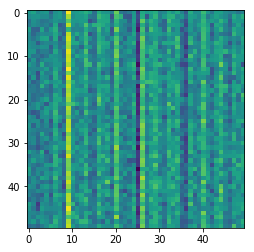

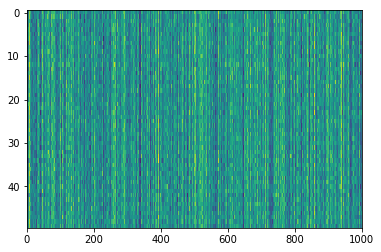

In [217]:
pl.imshow(mutr)
pl.show()
pl.imshow(lgts, aspect='auto')

In [111]:
lgts = sess.run(nonmutant_logits,feed_dict={inp:x})
lgts

array([[-0.20469926,  0.0571753 ],
       [-0.21424793,  0.03548675],
       [-0.16742229,  0.02762589],
       [-0.20520927, -0.03365123],
       [-0.14130846, -0.06362843]], dtype=float32)

In [64]:
loss = sparse_softmax_cross_entropy_with_logits(logits=mutant_logits, labels=)

array([[  8.04288617e-08,   2.40806660e-16,   1.17593041e-26,
          1.41943000e-10,   3.33094404e-09,   1.24746515e-35,
          3.15020312e-01,   2.83003309e-64,   1.38237958e-44,
          3.16241214e-11],
       [  1.31899414e-02,   3.26509884e-06,   1.00000000e+00,
          3.54041221e-11,   7.16227336e-17,   1.00000000e+00,
          3.94992454e-03,   8.97890337e-62,   3.25844867e-57,
          3.40193123e-03],
       [  4.65046683e-09,   6.87975006e-09,   4.79601400e-22,
          1.00000000e+00,   2.07369827e-12,   1.44908315e-42,
          6.81029763e-01,   1.00000000e+00,   1.00000000e+00,
          9.96598069e-01],
       [  9.86809974e-01,   9.99996728e-01,   7.36527069e-25,
          1.37109436e-17,   9.99999997e-01,   2.49000933e-44,
          4.73925460e-33,   1.10540607e-64,   5.58234886e-61,
          6.62819793e-11]])

In [66]:
?tf.nn.softmax
